In [215]:
import pandas as pd
from yelpapi import YelpAPI
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation

import time

%matplotlib inline

ISSDTTM and EXPDTTM,which stand for “issued date and time” and “expired date and time”

In [216]:
key_data=pd.read_csv('keys.csv', header=None)
key_data = key_data.set_index(0).transpose()



In [217]:
#This takes about a minute to run because it needs to parse the dates.
temp = pd.read_csv('Food_Establishment_Inspections.csv', low_memory=False,parse_dates=[12], infer_datetime_format=True)

In [218]:
data = temp
data.rename(columns = {'RESULTDTTM':'Date'}, inplace=True)
features = ['BusinessName', 'LegalOwner', 'ViolLevel', 'RESULT', 'Zip', 'Date', 'Address', 'City']

data=data[features]
data.loc[:,'ViolLevel'] = data['ViolLevel'].map({'*': 1, '**': 2, '***':3})

#Remove locations with date error
data = data[(data.RESULT != 'DATAERR') & (data.RESULT != 'HE_OutBus') & (data.RESULT != 'HE_NotReq') & 
            (data.RESULT != 'HE_Misc') & (data.RESULT != 'HE_TSOP')]

data.loc[:,'RESULT'] = data['RESULT'].map({'HE_Closure': 0,'HE_Fail':0,
                    'Fail':0, 'Failed':0, 'HE_FAILNOR':0,
                    'HE_FailExt':0, 'HE_Filed':0,
                    'HE_Hearing':0,'HE_Hold':0,
                    'HE_Pass':1, 'Pass':1})
data.shape

(335946, 8)

In [219]:
data=data.join(pd.get_dummies(data.ViolLevel).iloc[:,:3])

grouped=data.groupby(['BusinessName', 'Address', 'Date'])

clean_data = grouped.sum()
clean_data.head()


ViolLevel  \
BusinessName              Address              Date                             
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34        NaN   
                                               2010-07-26 10:05:35          6   
                                               2010-08-04 10:11:58          6   
                                               2011-02-09 11:05:14          2   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00        NaN   

                                                                    RESULT  \
BusinessName              Address              Date                          
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34       1   
                                               2010-07-26 10:05:35       0   
                                               2010-08-04 10:11:58       6   
                                               2011-02-09 11:05:14       0   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00       1   

                                                                    1.0  2.0  \
BusinessName              Address              Date                            
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34    0    0   
                                               2010-07-26 10:05:35    6    0   
                                               2010-08-04 10:11:58    6    0   
                                               2011-02-09 11:05:14    2    0   
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00    0    0   

                                                                    3.0  
BusinessName              Address              Date                      
1000 Washington Cafe      1000   Washington ST 2010-03-18 10:05:34    0  
                                               2010-07-26 10:05:35    0  
                                               2010-08-04 10:11:58    0  
                                               2011-02-09 11:05:14    0  
125 Nashua St. Cafe (MGH) 125  Nashua St       2015-07-10 10:59:00    0

In [267]:
long_clean = clean_data.reset_index()
long_clean['ID'] = long_clean['BusinessName'] +':' + long_clean['Address']

long_clean.head(5)

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID
0,1000 Washington Cafe,1000 Washington ST,2010-03-18 10:05:34,NaN,1,0,0,0,1000 Washington Cafe:1000 Washington ST
1,1000 Washington Cafe,1000 Washington ST,2010-07-26 10:05:35,6,0,6,0,0,1000 Washington Cafe:1000 Washington ST
2,1000 Washington Cafe,1000 Washington ST,2010-08-04 10:11:58,6,6,6,0,0,1000 Washington Cafe:1000 Washington ST
3,1000 Washington Cafe,1000 Washington ST,2011-02-09 11:05:14,2,0,2,0,0,1000 Washington Cafe:1000 Washington ST
4,125 Nashua St. Cafe (MGH),125 Nashua St,2015-07-10 10:59:00,NaN,1,0,0,0,125 Nashua St. Cafe (MGH):125 Nashua St


In [268]:
# create number representing days passed since last inspection date and current inspection date. first entry for a restaurant is set at 0 delta
temp_df = long_clean[['ID', 'Date']]
temp_df.loc[:,'temp_date'] = temp_df['Date']
g = temp_df.groupby(['ID', 'Date'])
delta = g.temp_date.first().diff()

for i in delta.index.levels[0]:
    delta[i][0] = 0  # won't allow np.nan or pd.NaT directly

In [269]:
long_clean['Delta_t']=delta.values

long_clean['Zip'] = grouped.first().Zip.values
long_clean.loc[:,'Delta_t'] = long_clean.Delta_t.dt.days

long_clean=long_clean[~long_clean.Zip.isnull()]
long_clean.RESULT[long_clean.RESULT > 0] = 1
print(long_clean.RESULT.sum() / float(long_clean.RESULT.shape[0]))

In [9]:
taco = long_clean[long_clean['BusinessName'].str.contains('TACO MEX')]
taco['Year'] =  taco.Date.dt.year
taco.RESULT[taco.RESULT > 0] = 1
# taco['Delta_t'] = (taco['Delta_t']/np.timedelta64(1,'D')).astype(int)

# plt.plot(taco.Date.values, taco.ViolLevel.values, 'bo')
# plt.plot(taco.Date[taco.RESULT>0], taco.Delta_t[taco.RESULT>0], '.', markersize=10, label="Pass")
# plt.plot(taco.Date[taco.RESULT==0], taco.Delta_t[taco.RESULT==0]+1, 'rs', markeredgewidth=1, markersize=5, label="Fail")
# plt.xlabel('Time since last inspection')
# plt.ylabel('Date of Inspection')
# plt.title('Taco Mex - History')
# plt.legend(frameon=True)
# plt.savefig('Taco_Mex.pdf')

# delta_pass.mean(), delta_fail.mean()

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/damienrj/miniconda/lib/python2.7/site-packages/pandas/core/generic.py:4059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

In [271]:
long_clean['Result_last'] = long_clean.groupby(['ID'])['RESULT'].transform(lambda x:x.shift())
long_clean['Date_last'] = long_clean.groupby(['ID'])['Date'].transform(lambda x:x.shift())

long_clean['Result_last'][long_clean.Result_last.isnull()]=-1
long_clean['Date_last'][long_clean.Result_last.isnull()]=-1

long_clean['Day_of_week'] = long_clean.Date_last.dt.dayofweek
long_clean['Month'] = long_clean.Date_last.dt.month
long_clean['Year'] = long_clean.Date_last.dt.year
long_clean['Quarter'] = long_clean.Date_last.dt.quarter
long_clean = long_clean.join(pd.get_dummies(long_clean.Result_last, prefix='Old_Result').iloc[:, 1:3])
long_clean.head(5)

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [603]:
long_clean.head()

,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,ID,Delta_t,Zip,Result_last,Date_last,Day_of_week,Month,Year,Quarter,Old_Result_0.0,Old_Result_1.0
1,1000 Washington Cafe,1000 Washington ST,2010-07-26 10:05:35,6,0,6,0,0,1000 Washington Cafe:1000 Washington ST,130,02118,1,2010-03-18 10:05:34,3,3,2010,1,0,1
2,1000 Washington Cafe,1000 Washington ST,2010-08-04 10:11:58,6,1,6,0,0,1000 Washington Cafe:1000 Washington ST,9,02118,0,2010-07-26 10:05:35,0,7,2010,3,1,0
3,1000 Washington Cafe,1000 Washington ST,2011-02-09 11:05:14,2,0,2,0,0,1000 Washington Cafe:1000 Washington ST,189,02118,1,2010-08-04 10:11:58,2,8,2010,3,0,1
6,129 Lake Street Cafe,127 LAKE ST,2012-10-25 11:56:14,1,0,1,0,0,129 Lake Street Cafe:127 LAKE ST,240,02135,0,2012-02-28 11:01:10,1,2,2012,1,1,0
7,129 Lake Street Cafe,127 LAKE ST,2013-10-23 13:17:41,0,1,0,0,0,129 Lake Street Cafe:127 LAKE ST,363,02135,0,2012-10-25 11:56:14,3,10,2012,4,1,0


Boston appears to give the same violations with a passed status once the previous violations have been taken care of.

clean_data.groupby(level=0).sum().sort_values(3, ascending=False).head(5)

# Section for pulling data from yelp
Yelp data is saved with pickle so that it doesn't need to be rerun until the file needs updating.

In [604]:
# keys = pd.read_csv('keys.csv', header=None)
# keys.set_index(0, inplace=True)

# keys=keys[1].to_dict()

In [607]:
# resturants = long_clean.groupby('ID').last()
# resturants.head()

# names = resturants.BusinessName


# names = clean_data.groupby(level=0).groups
# names = names.keys()

# names

In [ ]:
#This will take 30 minutes to run.
# results = []

# for a in xrange(0,len(names)+1 ):
#     string ='{}-boston'.format(str.replace(names[a], ' ', '-')).lower()
#     string = string.replace("'", '')
#     time.sleep(.2)
#     try:
#         result = yelp_api.business_query(string)
#         results.append(result)

#     except Exception as e:
#         results.append(False)
    
# resturants['yelp']=results

In [615]:
# resturants.to_pickle('YelpDataFrame.p')
resturants=pd.read_pickle('YelpDataFrame.p')

In [616]:
yelp_resturants = resturants[resturants.yelp!=False]
yelp_resturants.reset_index(inplace=True)
yelp_data = yelp_resturants.join(pd.io.json.json_normalize(yelp_resturants.yelp.values))

In [617]:
yelp_data.head(2)

,ID,BusinessName,Address,Date,ViolLevel,RESULT,1.0,2.0,3.0,Delta_t,...,phone,rating,rating_img_url,rating_img_url_large,rating_img_url_small,review_count,reviews,snippet_image_url,snippet_text,url
0,224 BOSTON STREET:224 Boston ST,224 BOSTON STREET,224 Boston ST,2015-01-13 14:32:59,9,1,6,0,1,6,...,6172651217,4.0,http://s3-media4.fl.yelpcdn.com/assets/2/www/i...,http://s3-media2.fl.yelpcdn.com/assets/2/www/i...,http://s3-media4.fl.yelpcdn.com/assets/2/www/i...,156,"[{u'rating': 4, u'excerpt': u'Went here last n...",http://s3-media3.fl.yelpcdn.com/photo/n4k57JXW...,Went here last night for my mom's Birthday din...,http://www.yelp.com/biz/224-boston-street-rest...
1,28 DEGREES:1 Appleton ST,28 DEGREES,1 Appleton ST,2012-05-17 12:38:55,9,0,9,0,0,6,...,6177280728,3.5,http://s3-media1.fl.yelpcdn.com/assets/2/www/i...,http://s3-media3.fl.yelpcdn.com/assets/2/www/i...,http://s3-media1.fl.yelpcdn.com/assets/2/www/i...,237,"[{u'rating': 4, u'excerpt': u'I can only speak...",http://s3-media1.fl.yelpcdn.com/photo/DYhpLZ8Z...,I can only speak the the happy hour $1 oyster ...,http://www.yelp.com/biz/28-degrees-boston?utm_...


## This section of the code is for the machine learning

In [587]:
#Makes any resturant who got a clean bill of health get a ViolLevel of 0
long_clean['ViolLevel'][(long_clean['RESULT']==1) & (long_clean['ViolLevel'].isnull())]=0

#Drop rows with NA, mostly coming from the requirement to have two inspections so that there is a previous result.
long_clean = long_clean.dropna()

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [589]:
#Add yelp data to clean data, with one hot encoding for the Yelp features.
yelp_data = yelp_data[['ID', 'rating', 'location.neighborhoods', 'categories', 'is_closed']]
yelp_data.dropna(inplace=True)
yelp_clean = long_clean.merge(yelp_data, on='ID')
yelp_clean['neighborhoods'] = yelp_clean['location.neighborhoods'].apply(lambda x: x[0])
yelp_clean['type']= yelp_clean['categories'].apply(lambda x: x[0][0])
yelp_clean = yelp_clean.join(pd.get_dummies(yelp_clean.neighborhoods).iloc[:, 0:-1])
yelp_clean = yelp_clean.join(pd.get_dummies(yelp_clean.type).iloc[:, 0:-1])
# yelp_clean['Old_Result_1.0']

In [590]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.cross_validation as cv

features = ['Delta_t', 'Day_of_week', 'Month', 'Year', 'Quarter', 'Zip', 'Old_Result_1.0', 'rating', 'Allston/Brighton',
       u'Back Bay', u'Beacon Hill', u'Central Square', u'Charlestown',
       u'Chinatown', u'Dorchester', u'Downtown', u'Dudley Square',
       u'East Boston', u'East Cambridge', u'Fenway', u'Fields Corner',
       u'Financial District', u'Hyde Park', u'Jamaica Plain', u'Mattapan',
       u'Mattapan Square', u'Mission Hill', u'North End', u'Roslindale',
       u'Roslindale Village', u'South Boston', u'South End',
       u'Uphams Corner', u'Waterfront', u'Adult Entertainment', u'African',
       u'American (New)', u'American (Traditional)', u'Asian Fusion',
       u'Bagels', u'Bakeries', u'Bars', u'Bed & Breakfast',
       u'Boat Charters', u'Boating', u'Bookstores', u'Boot Camps',
       u'Brasseries', u'Brazilian', u'Breakfast & Brunch', u'Breweries',
       u'Bubble Tea', u'Buffets', u'Burgers', u'Cafes', u'Cantonese',
       u'Caribbean', u'Caterers', u'Cheesesteaks', u'Chicken Wings',
       u'Chinese', u'Cocktail Bars', u'Coffee & Tea',
       u'Colleges & Universities', u'Colombian', u'Comedy Clubs',
       u'Community Service/Non-Profit', u'Convenience Stores',
       u'Creperies', u'Dance Clubs', u'Delis', u'Desserts', u'Dim Sum',
       u'Diners', u'Dive Bars', u'Do-It-Yourself Food', u'Dominican',
       u'Donuts', u'Drugstores', u'Ethiopian', u'Falafel',
       u'Farmers Market', u'Fast Food', u'Food Stands', u'Food Trucks',
       u'French', u'German', u'Gluten-Free', u'Greek', u'Grocery',
       u'Guest Houses', u'Gyms', u'Health & Medical', u'Hookah Bars',
       u'Hospitals', u'Hotels', u'Ice Cream & Frozen Yogurt', u'Indian',
       u'Indonesian', u'Irish', u'Italian', u'Japanese', u'Jazz & Blues',
       u'Juice Bars & Smoothies', u'Korean', u'Latin American',
       u'Lebanese', u'Lounges', u'Malaysian', u'Mediterranean', u'Mexican',
       u'Middle Eastern', u'Modern European', u'Mongolian', u'Museums',
       u'Music Venues', u'Nightlife', u'Performing Arts',
       u'Peruvian', u'Pizza', u'Polish', u'Pool Halls', u'Pubs', u'Ramen',
       u'Restaurants', u'Salad', u'Salvadoran', u'Sandwiches', u'Seafood',
       u'Seafood Markets', u'Shoe Stores', u'Soup', u'Southern',
       u'Spanish', u'Specialty Food', u'Sports Bars', u'Steakhouses',
       u'Street Vendors', u'Sushi Bars', u'Szechuan', u'Taiwanese',
       u'Tapas Bars', u'Tex-Mex', u'Thai', u'Tobacco Shops',
       u'Trinidadian', u'Turkish', u'Vegan', u'Venues & Event Spaces',
       u'Vietnamese']

# features = ['Delta_t', 'Day_of_week', 'Month', 'Year', 'Quarter', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0']
# features = ['Delta_t', 'Zip', 'Old_Result_0.0', 'Old_Result_1.0']
#long_clean.RESULT[long_clean.RESULT > 0] = 1

# Xtrain,Xtest,Ytrain,Ytest = cv.train_test_split(long_clean[['Delta_t', 'Zip']],long_clean['RESULT'].values, test_size=0.20)
Xtrain,Xtest,Ytrain,Ytest = cv.train_test_split(yelp_clean[features],yelp_clean['RESULT'].values, test_size=0.20)

In [593]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_leaf=3)
clf.verbose = False
clf.n_jobs = -1
#clf.fit(train[features], np.log1p(train['Sales']))
clf.fit(Xtrain, Ytrain)


#When ready to predict final values, train on full dataset
# clf.fit(yelp_clean[features], yelp_clean['RESULT'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [ ]:
cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

In [ ]:
#Tried different methods, small to no improvement with Gradient boosting, and the number of categorical features made Logistic Regression impractical. 

# from sklearn import ensemble
# clf = ensemble.GradientBoostingClassifier(n_estimators=2000, max_depth=3)
# clf.fit(Xtrain, Ytrain)

# from sklearn.linear_model import LogisticRegression
# clf=LogisticRegression(C=1., solver='lbfgs')
# clf.fit(Xtrain, Ytrain)
# cross_validation.cross_val_score(clf, Xtrain, Ytrain, cv=3, n_jobs=-1)

In [431]:
print(clf.score(Xtest, Ytest))

from sklearn.metrics import f1_score
print(f1_score(Ytest, clf.predict(Xtest)))

0.733847065797
0.685574229692


In [297]:
indices = np.argsort(clf.feature_importances_)[::-1]
print("Feature ranking:")

for f in xrange(0, 10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 0 (0.322948)
2. feature 6 (0.194600)
3. feature 3 (0.061482)
4. feature 5 (0.057660)
5. feature 2 (0.050103)
6. feature 1 (0.039660)
7. feature 7 (0.039279)
8. feature 4 (0.025551)
9. feature 77 (0.008927)
10. feature 33 (0.008083)


# Graphs for validation and data story, and additonal validation

In [298]:
feature_importance = clf.feature_importances_[0:9]
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[9:35]))
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[35:]))

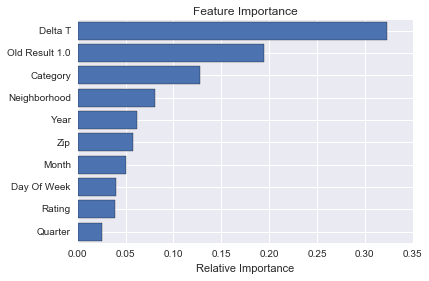

In [377]:
feature_importance = clf.feature_importances_[0:8]
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[8:34]))
feature_importance = np.append(feature_importance, sum(clf.feature_importances_[34:]))
features_short=features[0:8]
features_short.append('Neighborhood')
features_short.append('Category')
features_short = [str.join(' ', x.split('_')).title() for x in features_short]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
labels = [features_short[x] for x in sorted_idx]
plt.yticks(pos, labels)
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
# plt.savefig('yelp_importance.pdf', bbox_inches='tight')

In [498]:
#Find the amount of inspections that had back to back passing scores (11%)
test=long_clean[['Result_last', 'RESULT', 'Delta_t']]
# test = test[test.Delta_t>30]
print((test.Result_last==1) & (test.RESULT==1)).sum()
test.shape

6479


(58936, 3)

In [623]:
#Find precentage of passing inspections after the short initial window 28%

test=long_clean[['Result_last', 'RESULT', 'Delta_t']]
test = test[test.Delta_t>30]
print(test.RESULT.sum())
test.shape


9254


(32877, 3)

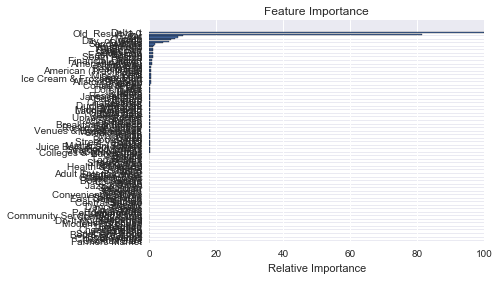

In [29]:
# Plot feature importance with catagories split
# feature_importance = clf.feature_importances_
# # make importances relative to max importance
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# labels = [features[x] for x in sorted_idx]
# plt.yticks(pos, labels)
# plt.xlabel('Relative Importance')
# plt.title('Feature Importance')

# plt.savefig('importance.pdf', bbox_inches='tight')

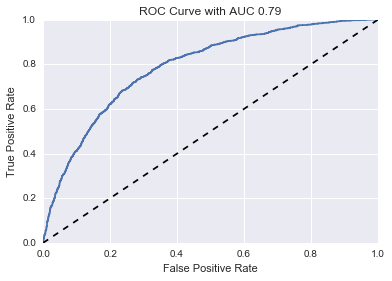

In [594]:
from sklearn import metrics
sns.set_style("darkgrid")
preds = clf.predict_proba(Xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(Ytest, preds)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC {0:.2f}'.format(metrics.auc(fpr, tpr)))

# plt.savefig('yelp_ROC.pdf', bbox_inches='tight')

/Users/damienrj/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


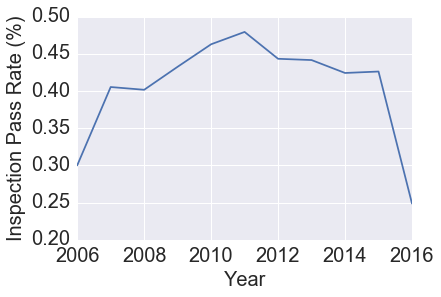

In [380]:
plot_data = clean_data.reset_index()
plot_data['Year']=plot_data.Date.dt.year
plot_data.RESULT[plot_data['RESULT'] > 0] = 1
plot_data.groupby('Year').mean().RESULT.plot(fontsize=20)
plt.ylabel("Inspection Pass Rate (%)", fontsize=20)
plt.xlabel('Year', fontsize=20)
# plt.title('Odds of inspection passing')
sns.set_style("darkgrid")
# plt.savefig('PassingRates.pdf', bbox_inches='tight')

## Move data to remote host

In [313]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

engine = create_engine('postgres://remote@localhost:63333/data')
print engine.url

con = None
con = psycopg2.connect(database = 'data', user = 'remote', port=63333, host='localhost')

# create_database(engine.url)

postgres://remote@localhost:63333/data


In [624]:
g3 = yelp_clean.groupby('ID')
test = g3.last()
test=test[['Result_last', 'RESULT', 'Delta_t']]
test = test[test.Delta_t>220]
print((test.RESULT==1)).sum()
test.shape

115


(210, 3)

In [626]:
test.head()

,Result_last,RESULT,Delta_t
ID,,,
973 Commonwealth:971 COMMONWEALTH AV,0,1,462
ALEX'S PIZZA:580 Dorchester AV,1,1,252
Allston Cafe:155 Brighton AV,0,0,418
Amelia's Taqueria:180 Brighton AV,1,0,227
B-Good:354 Longwood Av,1,1,356


In [466]:
g3 = yelp_clean.groupby('ID')
server_data = g3.last()
server_data.columns = [str(x).lower() for x in server_data.columns]
features_low = [str(x).lower() for x in features]

This section changes the delta t to the time since the last inspection. It also updates the last results to the last inspection and updates the time, and result columns. 

In [467]:
server_data['delta_t']=pd.to_datetime('2016-01-12')- server_data.date
server_data['delta_t']= (server_data['delta_t']/np.timedelta64(1,'D')).astype(int)
server_data['day_of_week']=server_data.date.dt.dayofweek
server_data['month']=server_data.date.dt.month
server_data['quarter']=server_data.date.dt.quarter
server_data['year']=server_data.date.dt.year

In [468]:
clf.predict(server_data[features_low]).sum()

216

In [469]:
server_data = server_data[server_data.delta_t < 365]

In [470]:
(clf.predict(server_data[features_low])).sum()

198

In [471]:
# temp = pd.get_dummies(server_data['result'])
# server_data['old_result_0.0']=temp[0]
server_data['old_result_1.0']=server_data['result']

In [473]:
# 12 percent of resturants passing with the later
server_data['pass'].sum()

105

In [474]:
server_data.shape

(858, 170)

In [630]:
server_data[['result', 'pass','pass_odds', 'fail_odds', 'delta_t' ]].sort_values('fail_odds').head(80)

,result,pass,pass_odds,fail_odds,delta_t
ID,,,,,
The Maiden:28 W Broadway,0,1,0.787286,0.212714,24
TACO MEX:65 Maverick SQ,0,1,0.762228,0.237772,5
HILTON BOSTON LOGAN AIRPORT:85 TERMINAL,0,1,0.748441,0.251559,21
Sportello:348 Congress ST,0,1,0.735514,0.264486,19
ANTHONY'S CAFE:252 Commercial ST,0,1,0.721840,0.278160,21
Pollo Campero:188 Border ST,0,1,0.709655,0.290345,3
Fenway Cafe:61 Brookline AV,0,1,0.695355,0.304645,14
SONSIE:327 Newbury ST,0,1,0.691999,0.308001,20
BARRY'S BOOTCAMP:38 Chauncy ST,0,1,0.680847,0.319153,20


In [476]:
server_data['pass']=clf.predict(server_data[features_low])
odds = clf.predict_proba(server_data[features_low])

server_data['pass_odds'] = odds[:, 1]
server_data['fail_odds'] = odds[:, 0]
server_data.businessname = server_data.businessname.str.lower()


In [490]:
selected_server_data= server_data[['businessname', 'address', 'delta_t', 'date', 'pass_odds', 'fail_odds', 'type', 'neighborhoods', 'pass']]
#remove closed resturants
selected_server_data = selected_server_data[server_data.is_closed == False]
selected_server_data.reset_index(inplace=True)


#Clean up data for sql database
selected_server_data.ID = selected_server_data.ID.str.replace("[ ]+", ' ')
selected_server_data.ID = selected_server_data.ID.str.title()

In [492]:
# selected_server_data.ID.values

array(['224 Boston Street:224 Boston St', '49 Social:49 Temple Pl',
       '5 Napkin Burger:101 Huntington Av',
       '7 Pond Coffee Bar:597 Centre St', '75 Chestnut:75 Chestnut St',
       '75 On Liberty Wharf:220 Northern Av',
       "Alfredo'S Italian Kitchen:243 Dorchester St",
       "Alfredo'S:229 Brighton Av",
       'Algonquin Club Of Boston:217 Commonwealth Av',
       'Ames Plow Tavern:200 Faneuil Hall Market Pl',
       "Amrhein'S:80 W Broadway", 'An Tain:31 India St',
       'Andrew Square House Of Pizza:395 Dorchester St',
       "Anthony'S Cafe:252 Commercial St", 'Antico Forno:93 Salem St',
       'Aquitaine:569 Tremont St', "Archie'S New York Deli:93 Arch St",
       'Artu:6 Prince', 'Artu:89 Charles St',
       'Atlantic Fish Company:761 Boylston St',
       'Addis Red Sea:540 Tremont St', "Amelia'S Taqueria:180 Brighton Av",
       "Amelia'S Taqueria:309 Huntington Av",
       'Americano Espresso Bar:155 Meridian St', 'Amorino:249 Newbury St',
       "Andre'S Cafe:80

In [493]:
selected_server_data[selected_server_data.ID=='Taco Mex:65 Maverick Sq']

,ID,businessname,address,delta_t,date,pass_odds,fail_odds,type,neighborhoods,pass
679,Taco Mex:65 Maverick Sq,taco mex,65 Maverick SQ,5,2016-01-06 12:58:13,0.762228,0.237772,Mexican,East Boston,1


In [494]:
#Copy data to server, requires port forwarding to be active via ssh
%%time
selected_server_data.to_sql('yelp2', con=engine)

CPU times: user 144 ms, sys: 63.5 ms, total: 207 ms
Wall time: 24.3 s


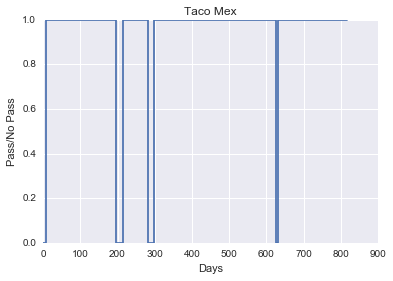

In [580]:
#Plot showing taco mex failing pattern
x = [0, 7, 7, 191+6,191+6, 196+6+5+7, 196+6+5+7,196+6+5+7+67, 196+6+5+7+67, 196+6+5+7+67+17,196+6+5+7+67+17, 196+6+5+7+67+17+327, 196+6+5+7+67+17+327, 196+6+5+7+67+17+327+6, 196+6+5+7+67+17+327+6, 196+6+5+7+67+17+327+6+187]
y = [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
plt.plot(x, y)
plt.xlabel('Days')
plt.ylabel('Pass/No Pass')
plt.title('Taco Mex')
# plt.savefig('pattern.pdf')

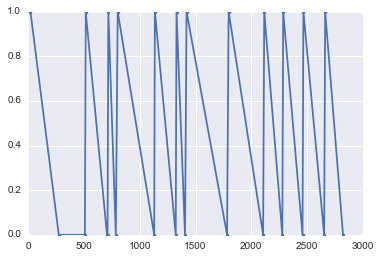

In [548]:
test = long_clean[long_clean.BusinessName=='TACO MEX']
total_days = np.cumsum(test.Delta_t)
len(total_days)


    
plt.plot(total_days, test.RESULT, '.-')

In [197]:
selected_server_data.sort_values('pass_odds', ascending=False)

,ID,businessname,address,delta_t,date,pass_odds,fail_odds,type,neighborhoods,pass
649,The Maiden:28 W Broadway,the maiden,28 W Broadway,24,2015-12-18 11:35:54,0.725350,0.274650,Wine Bars,South Boston,1
567,Sportello:348 Congress St,sportello,348 Congress ST,19,2015-12-23 10:29:59,0.716985,0.283015,Italian,Waterfront,1
303,Hilton Boston Logan Airport:85 Terminal,hilton boston logan airport,85 TERMINAL,21,2015-12-21 10:28:01,0.709116,0.290884,Hotels,East Boston,1
608,Taco Mex:65 Maverick Sq,taco mex,65 Maverick SQ,5,2016-01-06 12:58:13,0.707718,0.292282,Mexican,East Boston,1
12,Anthony'S Cafe:252 Commercial St,anthony's cafe,252 Commercial ST,21,2015-12-21 12:30:56,0.689064,0.310936,Italian,North End,1
261,Fenway Cafe:61 Brookline Av,fenway cafe,61 Brookline AV,14,2015-12-28 10:30:43,0.675842,0.324158,Coffee & Tea,Fenway,1
141,Carrie Nation:11 Beacon St,carrie nation,11 Beacon ST,5,2016-01-06 12:28:33,0.653518,0.346482,American (Traditional),Downtown,1
34,Barry'S Bootcamp:38 Chauncy St,barry's bootcamp,38 Chauncy ST,20,2015-12-22 15:25:10,0.650492,0.349508,Boot Camps,Downtown,1
520,Sonsie:327 Newbury St,sonsie,327 Newbury ST,20,2015-12-22 14:26:57,0.647873,0.352127,American (New),Back Bay,1
477,Pollo Campero:188 Border St,pollo campero,188 Border ST,3,2016-01-08 13:57:51,0.643097,0.356903,Latin American,East Boston,1


In [ ]:
selected_server_data[selected_server_data['ID'].str.contains('Taco Mex')]

In [ ]:
selected_server_data.sort_values('fail_odds')

In [ ]:
selected_server_data.ID.values[:-1]

In [ ]:
server_data.sort_values('pass_odds')[['businessname', 'address', 'delta_t', 'date', 'pass_odds']][:5].set_index('businessname')

In [ ]:
test=pd.read_sql_query("SELECT * FROM recent WHERE businessname = $$auntie anne's (no. ma 110)$$", engine)

In [ ]:
selected_server_data.sort_values('pass_odds')

In [ ]:
selected_server_data['businessname'][:-1].values

In [ ]:
pd.read_sql("SELECT * FROM recent WHERE businessname = $${}$$".format(temp), engine)

In [ ]:
query = "SELECT * FROM recent WHERE businessname = '{}'".format('129 Lake Street Cafe')
result = pd.read_sql_query(query, engine)
result.fail_odds_odds[0]


In [ ]:
import urlparse
urlparse.uses_query('aramark+%40+sullivan+%26+worcester')